In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [9]:
def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser

## Resuming from ckpt 9

In [6]:
args = get_command_line_args(["--checkpoint_dir=saved_models/",
                              "--filters=128",
                              "--dataset=cifar10",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                              "--resume_from=9",
                              "--batch_size=1000"
                             ])
configs.config_values = args

BEST_SIGMA_IDX = configs.config_values.num_L - 1
SIGMAS = utils.get_sigma_levels().numpy()
SIGMAS

Parameters: 

experiment: train
dataset: cifar10
model: refinenet
filters: 128
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 1000
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: 9
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2



array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [7]:
TEST_BATCH = 1000

# @tf.function
# def preproc(x):
#     x = tf.image.grayscale_to_rgb(x)
#     x =  tf.image.pad_to_bounding_box(x, offset_height=0, offset_width=0,
#                                      target_height=32, target_width=32)
#     return x

# with tf.device('CPU'):
# #     fashion_test = get_train_test_data("fashion_mnist")[1]
# #     fashion_test = fashion_test.shuffle(10000).batch(TEST_BATCH)
# #     fashion_test = fashion_test.map(preproc)
# #     fashion_test = fashion_test.cache()

gaussian_test_batches = [tf.random.normal(shape=(TEST_BATCH, 32,32)) for i in range(10)]


In [8]:
with tf.device('CPU'):
    celeb_test = get_train_test_data("celeb_a")[1]
    celeb_test = celeb_test.shuffle(20)
celeb_test_batches = [x for x in celeb_test][:10]

In [9]:
svhn_test_batches = []
svhn_test_labels = []

with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, data_dir="data", shuffle_files=True)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['test']).take(10000)
    svhn_test = svhn_test.batch(TEST_BATCH)
    
    for x in svhn_test:
        svhn_test_batches.append(x["image"] / 255)
        svhn_test_labels.append(x["label"])

In [13]:
cifar_test_batches = []
cifar_test_labels = []

@tf.function
def normalize(x):
    return x / 255

with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, data_dir="data", shuffle_files=True)
    cifar_train = tf.data.Dataset.from_tensor_slices(data_generators['train']['image'])
    cifar_train = cifar_train.map(normalize).batch(TEST_BATCH).cache()
    cifar_test_ = tf.data.Dataset.from_tensor_slices(data_generators['test']).batch(TEST_BATCH)
    
    for x in cifar_test_:
        cifar_test_batches.append(x["image"] / 255)
        cifar_test_labels.append(x["label"])

In [14]:
len(cifar_test_batches)

10

In [18]:
LABELS = np.array(["Train", "CIFAR", "CelebA", "SVHN"])
colors = ["red", "blue", "green", "orange"]

## Generating Samples

In [15]:
utils.get_savemodel_dir()

('saved_models/refinenet128_cifar10_L10_SH1e+00_SL1e-02/',
 'refinenet128_cifar10_L10_SH1e+00_SL1e-02')

In [16]:
save_dir, complete_model_name = utils.get_savemodel_dir() # "longleaf_models/baseline64_fashion_mnist_SL0.001", ""
model, optimizer, step, _, _ = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

(1, 32, 32, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 32, 32, 128)  302848      conv2d[0][0]                     
                                                                 idx_sigmas[0][

In [26]:
@tf.function(experimental_compile=True)
def reduce_norm(x):
    return tf.norm(tf.reshape(x, shape=(x.shape[0], -1)),
                   axis=1, ord="euclidean", keepdims=True)
    

### Getting Score Distributions

In [14]:
%%time

idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * BEST_SIGMA_IDX

for cifar_, svhn_, celeb_ in zip(cifar_test_batches, svhn_test_batches, celeb_test_batches):
#     fashion_logits = model([fashion_, idx_sigmas])
    celeb_logits = model([celeb_, idx_sigmas])
    cifar_logits = model([cifar_, idx_sigmas])
    svhn_logits = model([svhn_, idx_sigmas])
    break

CPU times: user 2.5 s, sys: 5.31 s, total: 7.81 s
Wall time: 7.83 s


In [19]:
# L2-norm same as Frobenius
f_train_svhn_score = tf.norm(svhn_logits, axis=[1,2], ord="euclidean").numpy()
f_train_celeb_score = tf.norm(celeb_logits, axis=[1,2], ord="euclidean").numpy()
f_train_cifar_score = tf.norm(cifar_logits, axis=[1,2], ord="euclidean").numpy()

In [20]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18

In [21]:
column_names = []

for c in ["R", "G", "B"]:
    for n in ["SVHN", "CIFAR"]:
        column_names.append(n+"_"+c)

df = pd.DataFrame(np.hstack((f_train_svhn_score[:,:],
                             f_train_cifar_score[:,:])),
             columns=column_names)
df.describe()

SVHN_R      CIFAR_R       SVHN_G      CIFAR_G       SVHN_B  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean   2091.447510  2160.821533  2117.207275  1467.223267  1522.869263   
std     104.943848   109.679222   129.982071   165.336823   191.037430   
min    1626.400269  1571.201660  1524.585327  1068.203491   781.238708   
25%    2032.936829  2095.143494  2035.452271  1346.425323  1389.768402   
50%    2101.006836  2179.682983  2125.176392  1452.800659  1513.329773   
75%    2162.370789  2239.328857  2205.301819  1584.920898  1652.075043   
max    2339.859131  2485.538330  2501.125732  2050.310303  2103.208252   

           CIFAR_B  
count  1000.000000  
mean   1444.243164  
std     178.883255  
min     943.436462  
25%    1307.623169  
50%    1429.673218  
75%    1562.658722  
max    2209.054932

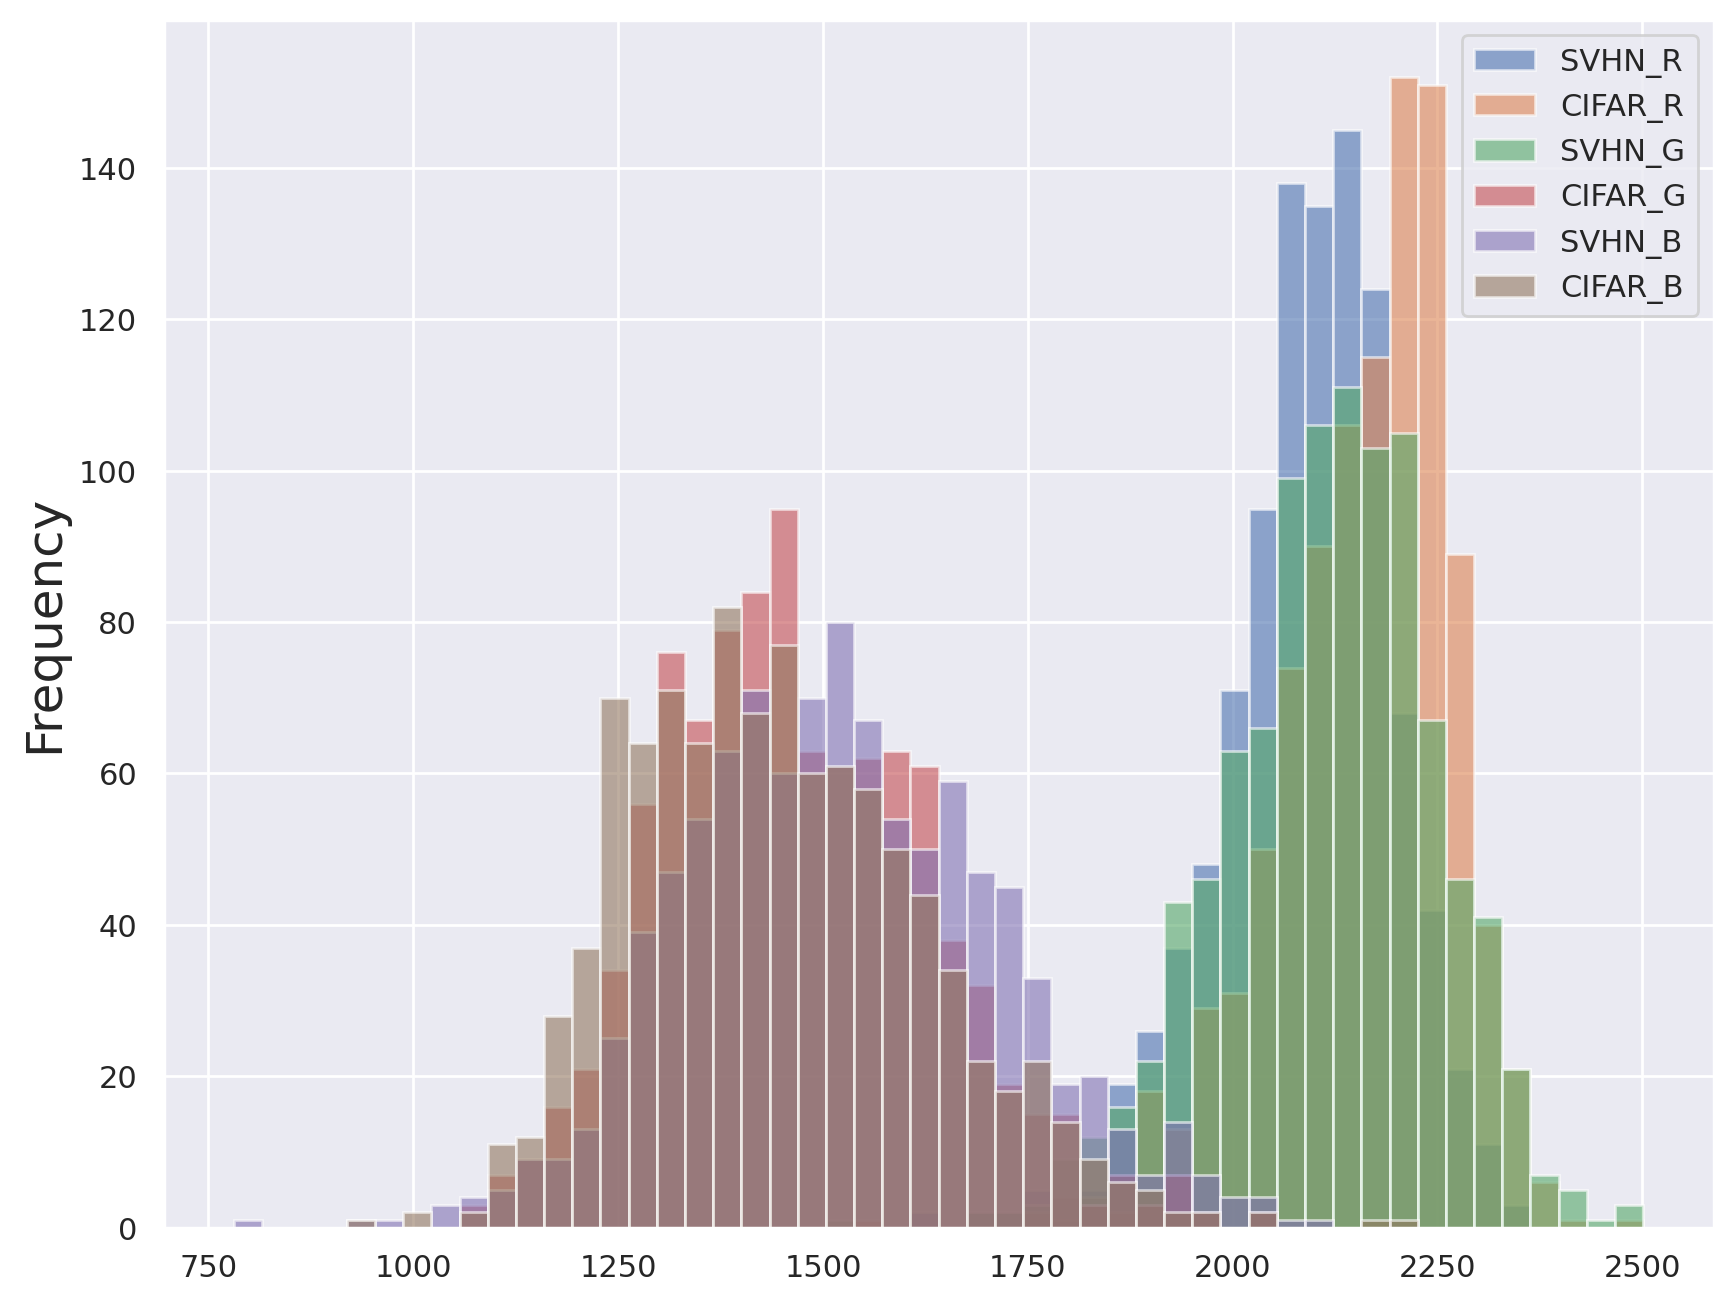

In [22]:
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))

In [27]:
%%time
svhn_score = reduce_norm(svhn_logits).numpy()
celeb_score = reduce_norm(celeb_logits).numpy()
cifar_score = reduce_norm(cifar_logits).numpy()

CPU times: user 4.51 ms, sys: 16.2 ms, total: 20.7 ms
Wall time: 18.1 ms


In [28]:
svhn_score.shape

(1000, 1)

SVHN       CelebA        CIFAR
count  1000.000000  1000.000000  1000.000000
mean   3679.054932  2809.675537  2562.604492
std     174.221664   162.842453   294.266327
min    2734.248291  2354.533936  1756.987671
25%    3571.356750  2698.172424  2342.063049
50%    3704.598755  2792.325562  2541.675049
75%    3801.698425  2901.046021  2768.678833
max    4110.201660  3390.010498  3538.035645

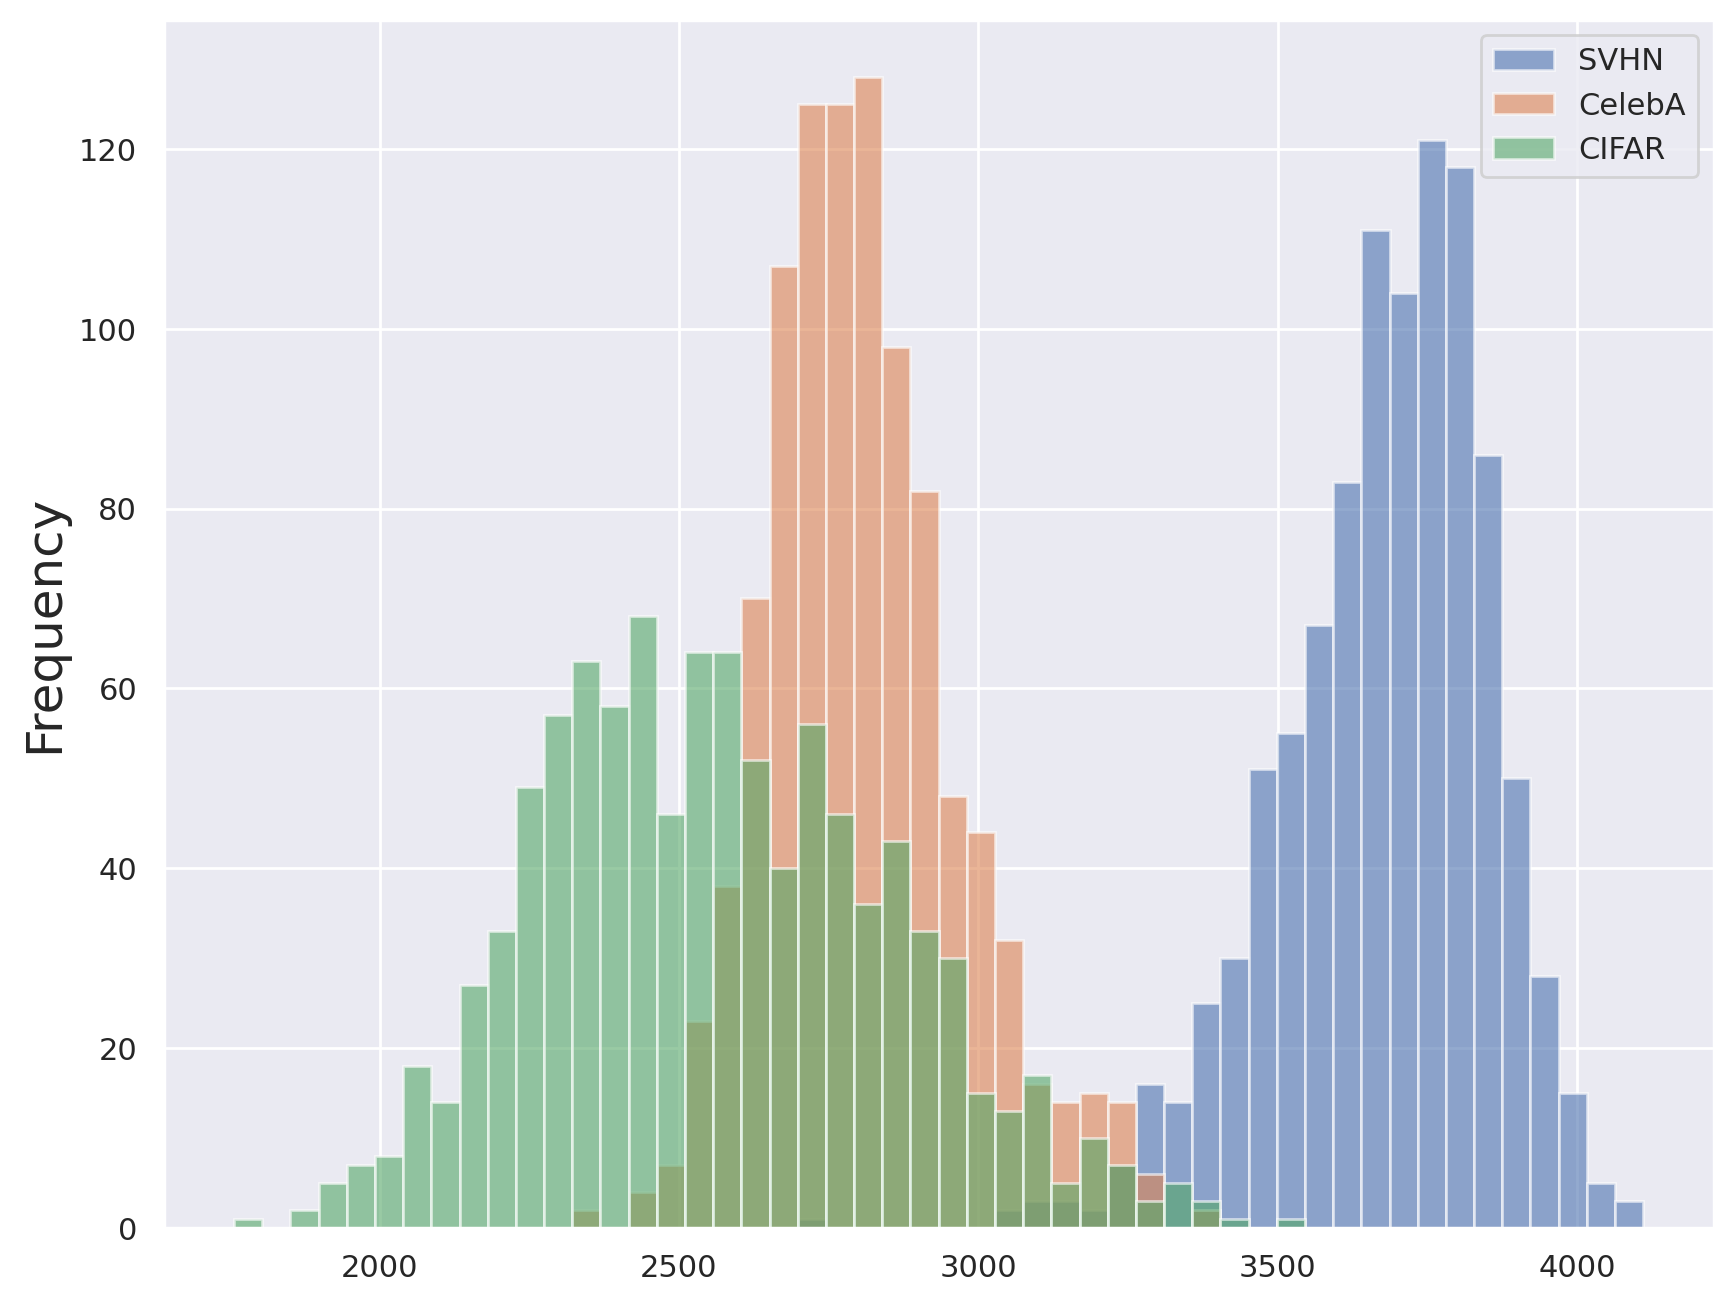

In [29]:
df = pd.DataFrame(np.hstack((svhn_score,
                            celeb_score,
                            cifar_score)),
                  columns=["SVHN", "CelebA", "CIFAR"])

df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))
df.describe()

### CIFAR vs SVHN

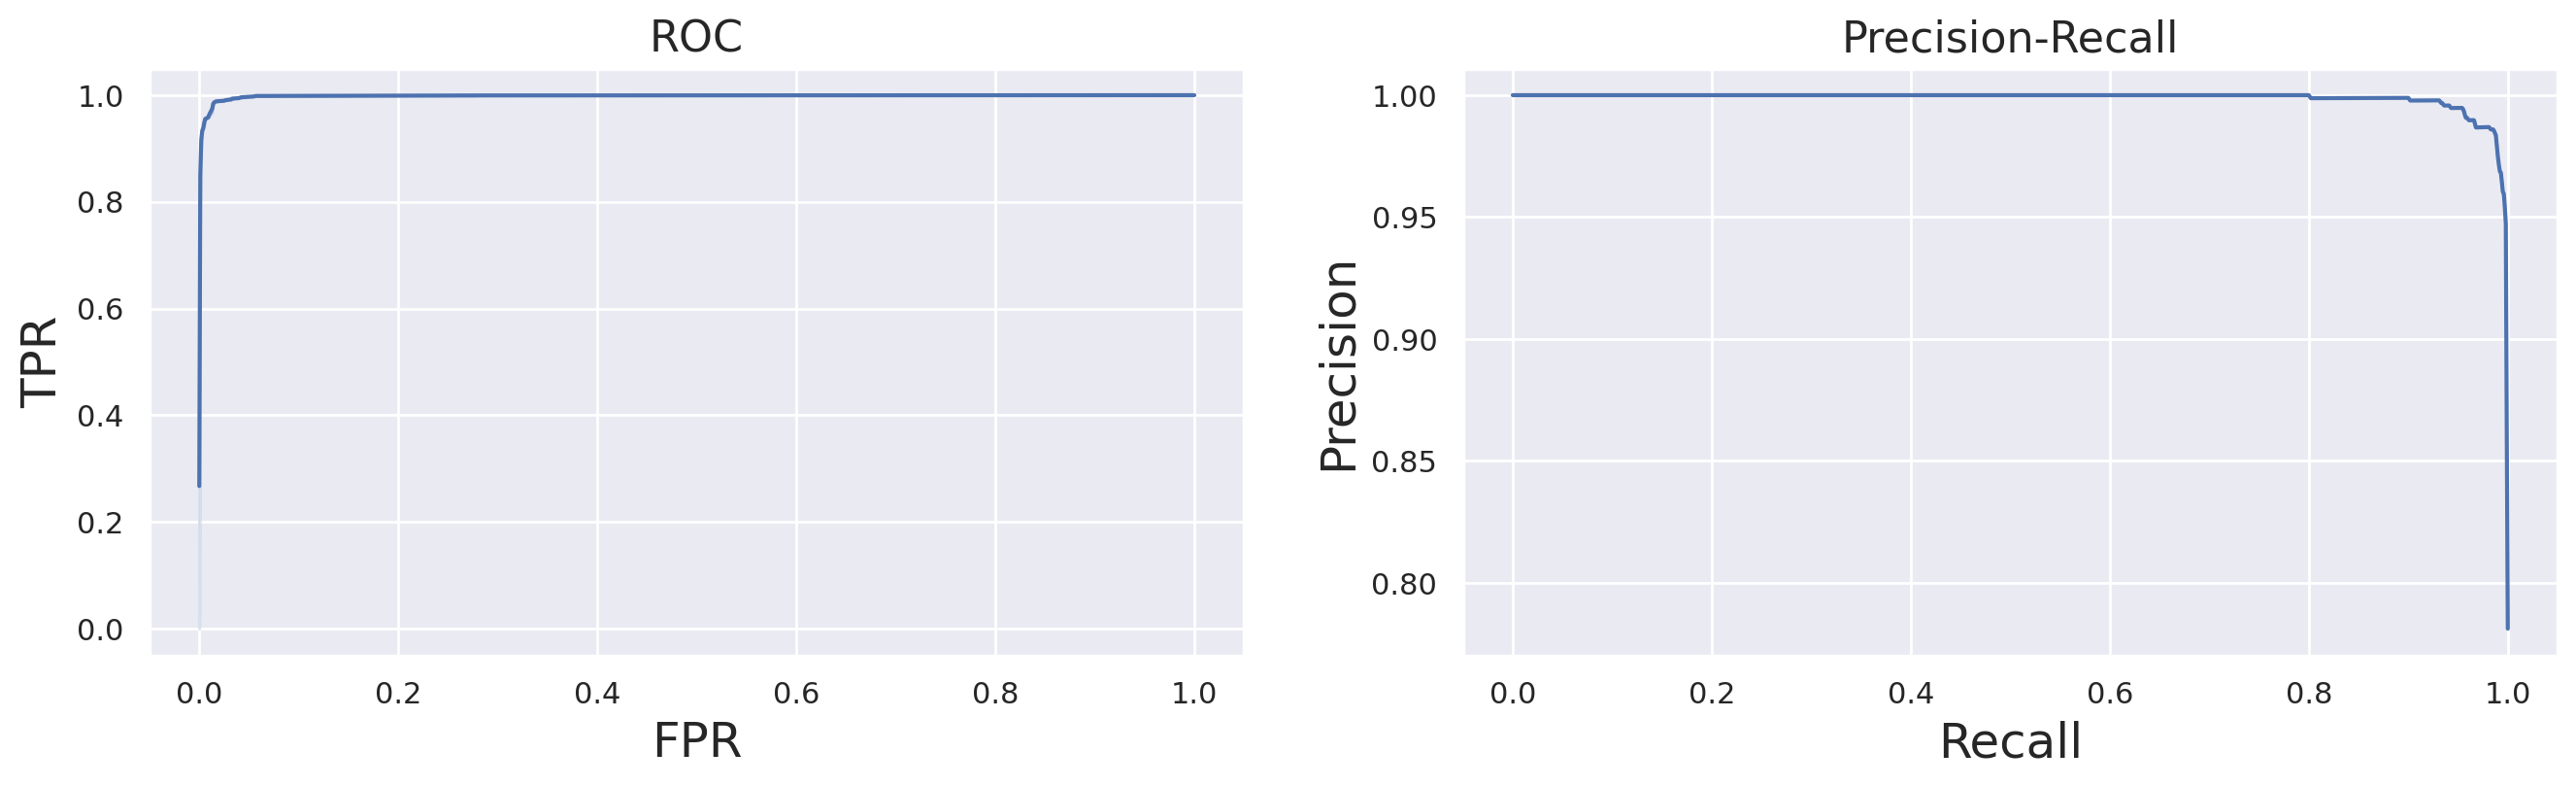

Inlier vs Outlier
----------------
ROC-AUC: 0.9987
PR-AUC: 0.9987
Avg Prec: 0.9987


In [31]:
metrics(cifar_score, svhn_score, plot=True, verbose=True)
plt.show()

### CIFAR vs CelebA

In [ ]:
metrics(cifar_score, celeb_score, plot=True, verbose=True)
plt.show()

# Using all norms

In [54]:
10*10000*32*32*3*4 // 1024**3

1

In [18]:
def compute_scores(x_test):
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = 0 #tf.zeros(logits_shape)
    progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]

        for x_batch in x_test:
            idx_sigmas = tf.ones(x_batch.shape[0], dtype=tf.int32) * idx
            score = model([x_batch, idx_sigmas])
#             x_batch, y_cond = tf.split(x_batch, SPLITS, axis=-1)
#             score = tf.where(x_batch > 1e-10, score,  0)
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
#         final_logits += _logits * sigma
    
    return score_dict

In [20]:
outlier_datasets = (celeb_test_batches, svhn_test_batches)

In [21]:
# %%time
# train_dist = compute_scores(cifar_train)

In [23]:
%%time
cifar_dist = compute_scores(cifar_test_batches)

Sigma: 0.0100: 100%|██████████| 10/10 [03:03<00:00, 18.33s/it]

CPU times: user 58.9 s, sys: 54.8 s, total: 1min 53s
Wall time: 3min 3s


In [24]:
%%time
outlier_dists = []
progress_bar = tqdm(zip(LABELS[2:], outlier_datasets))
for name, outlier in progress_bar:
    progress_bar.set_description(name)
    outlier_dists.append(compute_scores(outlier))

CelebA: : 0it [00:00, ?it/s]
Sigma: 0.0100: 100%|██████████| 10/10 [03:04<00:00, 18.41s/it]
SVHN: : 1it [03:04, 184.90s/it]  
Sigma: 0.0100: 100%|██████████| 10/10 [03:04<00:00, 18.43s/it]
SVHN: : 2it [06:10, 185.09s/it]

CPU times: user 1min 57s, sys: 1min 51s, total: 3min 49s
Wall time: 6min 10s


In [27]:
celeb_dist, svhn_dist = outlier_dists

In [37]:
# np.savez("scores.npz", celeba=celeb_dist, svhn=svhn_dist)

In [38]:
# L2-norm same as Frobenius
with tf.device("cpu"):
#     train_agg = tf.add_n([train_dist[x] * s for x, s in enumerate(SIGMAS)])
    inlier_agg = tf.add_n([cifar_dist[x] * s for x, s in enumerate(SIGMAS)])
    outlier_agg = tf.add_n([celeb_dist[x] * s for x,s in enumerate(SIGMAS)])
    outlier_agg_2 = tf.add_n([svhn_dist[x] * s for x,s in enumerate(SIGMAS)])

#     train_score = tf.reduce_mean(tf.norm(train_agg, axis=[1,2]), axis=1).numpy()[:, np.newaxis]
    cifar_score = reduce_norm(inlier_agg).numpy()
    celeb_score = reduce_norm(outlier_agg).numpy()
    svhn_score = reduce_norm(outlier_agg_2).numpy()

In [39]:
outlier_agg.shape

TensorShape([10000, 32, 32, 3])

In [40]:
df = pd.DataFrame(np.hstack((
#                 train_score[-len(cifar_score):],
                cifar_score[:TEST_BATCH*9],
                celeb_score[:TEST_BATCH*9],
                svhn_score[:TEST_BATCH*9])),
 columns=["CIFAR-Test", "CelebA", "SVHN"])
df.describe()

CIFAR-Test       CelebA         SVHN
count  9000.000000  9000.000000  9000.000000
mean    248.180389   266.155396   283.242737
std      18.532169    10.251641    19.505890
min     167.767410   207.599884   208.281769
25%     236.002895   259.518959   270.112732
50%     247.119240   266.294174   284.383499
75%     258.665184   272.835663   297.357849
max     341.737213   312.795105   347.998932

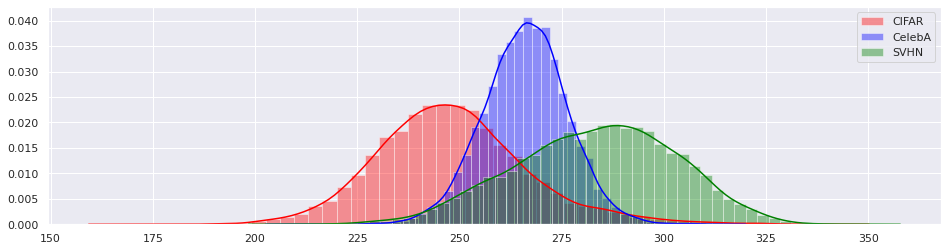

In [41]:
fig, ax = plt.subplots(1,1, figsize=(16,4))



for idx, sc in enumerate([cifar_score,
                          celeb_score,
                          svhn_score]):

    sns.distplot(sc, label=LABELS[idx+1], color=colors[idx], ax=ax)
plt.legend()
plt.show()

**CIFAR vs SVHN**

In [49]:
metrics(cifar_score, svhn_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9000
PR-AUC: 0.8877
Avg Prec: 0.8877


**CIFAR vs CelebA**

In [50]:
metrics(cifar_score, celeb_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.8159
PR-AUC: 0.7118
Avg Prec: 0.7118


## Train Data = L2-norm(Pixel Scores)

In [12]:
from ood_detection_helper import *

Parameters: 

experiment: train
dataset: mnist
model: refinenet
filters: 128
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: ./saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2



In [4]:
with open("scores.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [14]:
test_data = score_dict["cifar"]
outlier_data_1 = score_dict["celeba"]
outlier_data_2 = score_dict["svhn"]

In [16]:
# #### %%time
# train_data, test_data = [], []
# outlier_data_1, outlier_data_2 = [], [] 

# for x, s in enumerate(SIGMAS):
# #     train_data.append(tf.norm(fashion_train_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
#     test_data.append(reduce_norm(cifar_dist[x] * s).numpy())
#     outlier_data_1.append(reduce_norm(celeb_dist[x] * s).numpy())
#     outlier_data_2.append(reduce_norm(svhn_dist[x] * s).numpy())
    
# # train_data = np.concatenate(train_data, axis=1)
# test_data = np.concatenate(test_data, axis=1)
# outlier_data_1 = np.concatenate(outlier_data_1, axis=1)
# outlier_data_2 = np.concatenate(outlier_data_2, axis=1)

# # Shapes
# shapes = [test_data.shape, outlier_data_1.shape, outlier_data_2.shape]
# print(shapes)

# X_train, X_test =  test_data[:9000], test_data[9000:]

# # import pickle

# # with open("scores.p", "wb") as f:
# #     pickle.dump({
# #         "cifar": test_data,
# #         "celeba":outlier_data_1,
# #         "svhn": outlier_data_2
# #     }, f)

In [20]:
# Shapes
shapes = [test_data.shape, outlier_data_1.shape, outlier_data_2.shape]

samples = np.concatenate((test_data, outlier_data_1, outlier_data_2))

labels = np.concatenate((np.zeros(test_data.shape[0]),
                         np.ones(outlier_data_1.shape[0]),
                         2*np.ones(outlier_data_2.shape[0])))

captions = np.concatenate([[LABELS[idx]]*shapes[idx-1][0] for idx in range(1,4)])

[(10000, 10), (10000, 10), (10000, 10)]


# UMAP

### Score Norms

In [44]:
samples_train = np.concatenate((test_data[:9000], outlier_data_1[:9000], outlier_data_2[:9000]))
samples_test  = np.concatenate((test_data[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

samples_train.shape

(27000, 10)

In [45]:
%%time
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=15,
                    min_dist=0.1)
reducer.fit(samples_train)

CPU times: user 1min 22s, sys: 1min 13s, total: 2min 36s
Wall time: 50.6 s


UMAP(n_components=3, random_state=42)

In [46]:
%%time
embedding = reducer.transform(samples_test)

CPU times: user 23 s, sys: 415 ms, total: 23.5 s
Wall time: 18.9 s


In [47]:
embedding.shape

(3000, 3)

In [48]:
[shapes[idx-1][0]-9000 for idx in range(1,4)]

[1000, 1000, 1000]

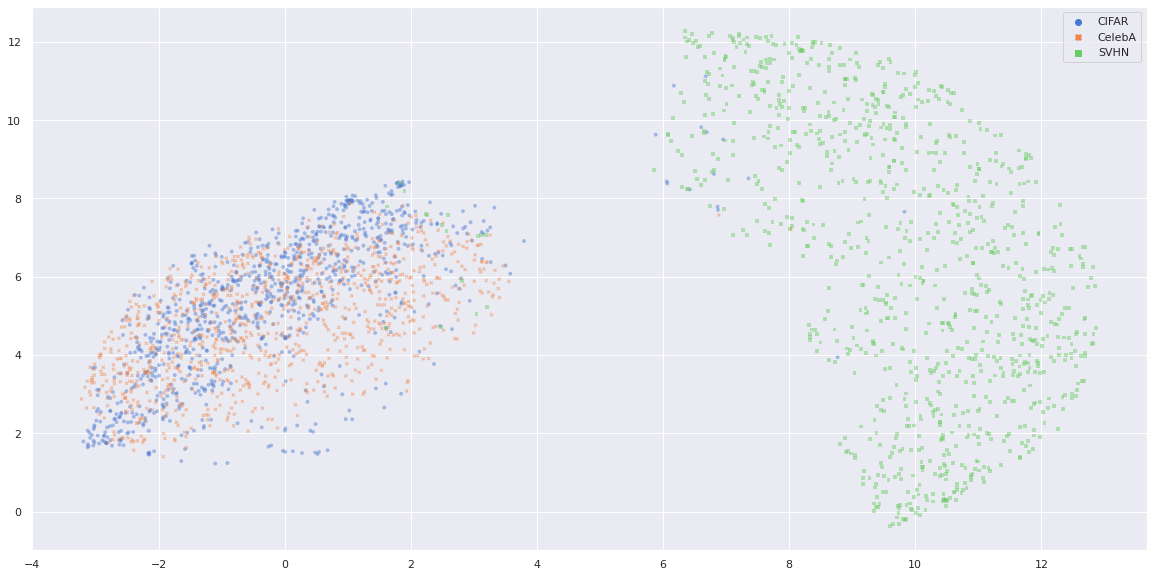

In [49]:
plt.figure(figsize=(20,10))

captions_test = np.concatenate([[LABELS[idx]]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
labels_test = np.concatenate([[idx]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
sns.scatterplot(x=embedding[:, 0],
                y=embedding[:, 1],
                hue=captions_test, style=captions_test, s=15, alpha=0.45, palette="muted", edgecolor="none")
plt.show()
# plt.close()

In [50]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Score Norms",
    marker=dict(
        size=2,
        color=labels_test,
        colorscale="Blackbody",
        opacity=0.5,
        showscale=True
    ),
    text=captions_test
)

layout = go.Layout(
    title="3D UMAP",
    autosize=False,
    width=1000,
    height=800,
#     paper_bgcolor='#F5F5F5',
#     template="plotly"
)

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
fig.show("notebook")

## GMM

In [21]:
X_train, X_test =  test_data[:9000], test_data[9000:]
outlier_train_1, outlier_train_2 = outlier_data_1[9000:], outlier_data_2[9000:]

In [42]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def evaluate_GMM_emb(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train_embedding)
    
    test_score = gmm_clf.score_samples(X_test_embedding)
    outlier_score = gmm_clf.score_samples(outlier_train_embedding_1)
    outlier_score_2 = gmm_clf.score_samples(outlier_train_embedding_2)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

def evaluate_GMM(n):
    gmm_clf = Pipeline([
#     ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train)
    
    test_score = gmm_clf.score_samples(X_test)
    outlier_score = gmm_clf.score_samples(outlier_train_1)
    outlier_score_2 = gmm_clf.score_samples(outlier_train_2)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [43]:
# %%time


# with ThreadPoolExecutor(max_workers = 4) as exc:
#     result = list(exc.map(evaluate_GMM, component_range))

In [55]:
%%time

max_n_component = 50
component_range = range(24, max_n_component+1, 2)

result = [evaluate_GMM(n) for n in component_range]
result = np.array(result)

CPU times: user 46min 27s, sys: 1h 7min 46s, total: 1h 54min 14s
Wall time: 2min 26s


Best -> n=38: 0.837 


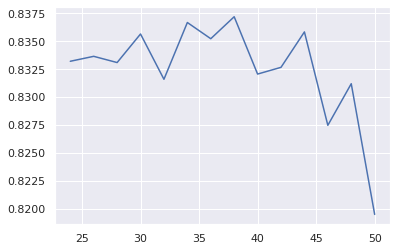

In [56]:
plt.plot(component_range, result)

print("Best -> n={}: {:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [61]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
#     ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**{"GMM__n_components":38})

best_gmm_clf.fit(X_train)

Pipeline(steps=[('GMM', GaussianMixture(n_components=38))])

In [62]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: -6.034
CIFAR Likelihood: -6.370
CelebA Likelihood: -8.289
SVHN Likelihood: -16.557


In [63]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

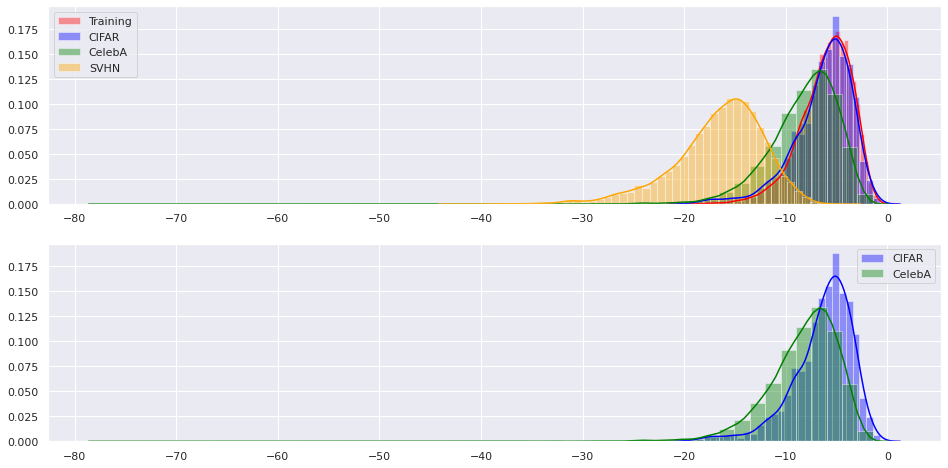

In [64]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

### AUPR-In

In [52]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9783
PR-AUC: 0.9970
Avg Prec: 0.9970


In [54]:
metrics(outlier_score_2, test_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9783
PR-AUC: 0.9203
Avg Prec: 0.9203


(0.9782692999999999, 0.9202829395577422, 0.92025828566857)

In [28]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(2,21,2),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   25.5s finished


CPU times: user 1min 34s, sys: 1min 23s, total: 2min 58s
Wall time: 29.4 s


Best: 2.357059 using {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
---------------------------------------------------------------------------
2.041103 (0.106443) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.250167 (0.092722) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.318037 (0.101584) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.351245 (0.091468) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.349406 (0.090313) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.357059 (0.091248) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.347783 (0.098766) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.344918 (0.096629) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.333245 (0.100364) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.318454 (0.092045) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


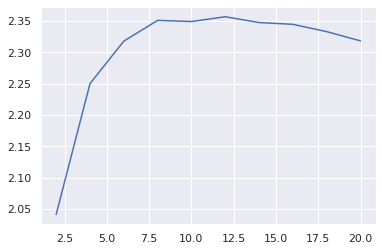

In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [34]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('GMM', GaussianMixture(n_components=12))])

In [35]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: 2.485
CIFAR Likelihood: 2.494
CelebA Likelihood: 0.675
SVHN Likelihood: -6.140


In [36]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

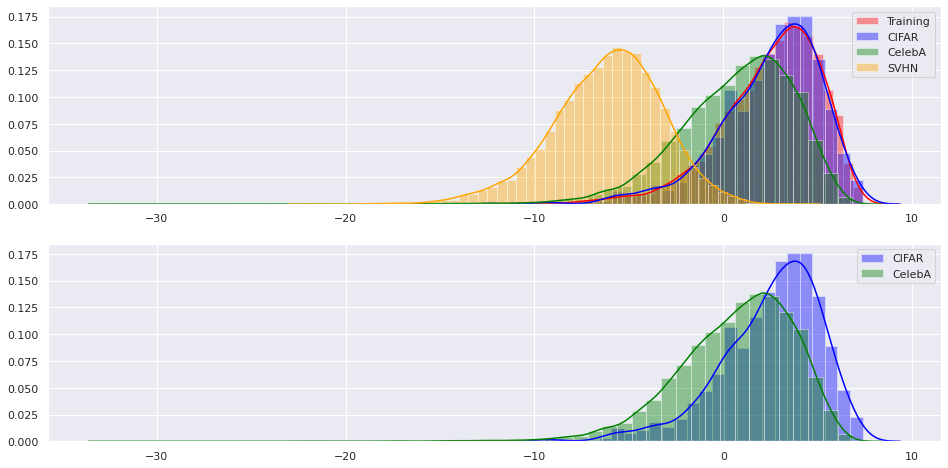

In [37]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

**CIFAR vs CelebA**

In [72]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.6519
PR-AUC: 0.9421
Avg Prec: 0.9421


**CIFAR vs SVHN**

In [81]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9706
PR-AUC: 0.9955
Avg Prec: 0.9955


### Flow Models

In [57]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [58]:
X_train.shape

(9000, 10)

In [59]:
scaler = StandardScaler()
s_X_train = scaler.fit_transform(X_train)

In [93]:
# Density estimation with MADE.
n = X_train.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[256, 256], activation="relu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob)

batch_size = 64
epochs = 500
history = model.fit(
    x=s_X_train,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Epoch 1/500
140/140 [==============================] - 0s 3ms/step - loss: 14.1744
Epoch 2/500
140/140 [==============================] - 0s 3ms/step - loss: 14.0650
Epoch 3/500
140/140 [==============================] - 0s 3ms/step - loss: 13.9854
Epoch 4/500
140/140 [==============================] - 0s 3ms/step - loss: 13.8852
Epoch 5/500
140/140 [==============================] - 0s 3ms/step - loss: 13.8076
Epoch 6/500
140/140 [==============================] - 0s 3ms/step - loss: 13.7056
Epoch 7/500
140/140 [==============================] - 0s 3ms/step - loss: 13.6195
Epoch 8/500
140/140 [==============================] - 0s 3ms/step - loss: 13.4628
Epoch 9/500
140/140 [==============================] - 0s 3ms/step - loss: 13.3246
Epoch 10/500
140/140 [==============================] - 0s 3ms/step - loss: 13.1951
Epoch 11/500
140/140 [==============================] - 0s 3ms/step - loss: 13.0214
Epoch 12/500
140/140 [==============================] - 0s 3ms/step - loss: 12.8132
E

140/140 [==============================] - 0s 3ms/step - loss: 2.5938
Epoch 100/500
140/140 [==============================] - 0s 3ms/step - loss: 2.6022
Epoch 101/500
140/140 [==============================] - 0s 3ms/step - loss: 2.4993
Epoch 102/500
140/140 [==============================] - 0s 3ms/step - loss: 2.4506
Epoch 103/500
140/140 [==============================] - 0s 3ms/step - loss: 2.4462
Epoch 104/500
140/140 [==============================] - 0s 3ms/step - loss: 2.3318
Epoch 105/500
140/140 [==============================] - 0s 3ms/step - loss: 2.2802
Epoch 106/500
140/140 [==============================] - 0s 3ms/step - loss: 2.3144
Epoch 107/500
140/140 [==============================] - 0s 3ms/step - loss: 2.2233
Epoch 108/500
140/140 [==============================] - 0s 3ms/step - loss: 2.1750
Epoch 109/500
140/140 [==============================] - 0s 3ms/step - loss: 2.1188
Epoch 110/500
140/140 [==============================] - 0s 3ms/step - loss: 2.0932
Epoch 

140/140 [==============================] - 0s 3ms/step - loss: -0.3653
Epoch 197/500
140/140 [==============================] - 0s 3ms/step - loss: -0.4769
Epoch 198/500
140/140 [==============================] - 0s 3ms/step - loss: -0.4712
Epoch 199/500
140/140 [==============================] - 0s 3ms/step - loss: -0.5063
Epoch 200/500
140/140 [==============================] - 0s 3ms/step - loss: -0.4675
Epoch 201/500
140/140 [==============================] - 0s 3ms/step - loss: -0.5361
Epoch 202/500
140/140 [==============================] - 0s 3ms/step - loss: -0.5316
Epoch 203/500
140/140 [==============================] - 0s 3ms/step - loss: -0.5409
Epoch 204/500
140/140 [==============================] - 0s 3ms/step - loss: -0.5642
Epoch 205/500
140/140 [==============================] - 0s 3ms/step - loss: -0.5803
Epoch 206/500
140/140 [==============================] - 0s 3ms/step - loss: -0.6086
Epoch 207/500
140/140 [==============================] - 0s 3ms/step - loss: -0

140/140 [==============================] - 0s 3ms/step - loss: -1.6023
Epoch 293/500
140/140 [==============================] - 0s 3ms/step - loss: -1.6107
Epoch 294/500
140/140 [==============================] - 0s 3ms/step - loss: -1.5953
Epoch 295/500
140/140 [==============================] - 0s 3ms/step - loss: -1.6337
Epoch 296/500
140/140 [==============================] - 1s 4ms/step - loss: -1.6179
Epoch 297/500
140/140 [==============================] - 0s 3ms/step - loss: -1.6587
Epoch 298/500
140/140 [==============================] - 0s 3ms/step - loss: -1.6143
Epoch 299/500
140/140 [==============================] - 0s 3ms/step - loss: -1.6555
Epoch 300/500
140/140 [==============================] - 0s 3ms/step - loss: -1.6559
Epoch 301/500
140/140 [==============================] - 0s 3ms/step - loss: -1.6442
Epoch 302/500
140/140 [==============================] - 0s 4ms/step - loss: -1.6597
Epoch 303/500
140/140 [==============================] - 0s 3ms/step - loss: -1

140/140 [==============================] - 0s 3ms/step - loss: -1.9768
Epoch 389/500
140/140 [==============================] - 0s 3ms/step - loss: -1.9889
Epoch 390/500
140/140 [==============================] - 0s 3ms/step - loss: -1.9760
Epoch 391/500
140/140 [==============================] - 0s 3ms/step - loss: -1.9923
Epoch 392/500
140/140 [==============================] - 0s 2ms/step - loss: -1.9947
Epoch 393/500
140/140 [==============================] - 0s 3ms/step - loss: -2.0068
Epoch 394/500
140/140 [==============================] - 0s 3ms/step - loss: -1.9717
Epoch 395/500
140/140 [==============================] - 0s 3ms/step - loss: -1.9997
Epoch 396/500
140/140 [==============================] - 0s 3ms/step - loss: -2.0177
Epoch 397/500
140/140 [==============================] - 0s 3ms/step - loss: -2.0010
Epoch 398/500
140/140 [==============================] - 0s 3ms/step - loss: -1.9930
Epoch 399/500
140/140 [==============================] - 0s 3ms/step - loss: -1

140/140 [==============================] - 0s 3ms/step - loss: -2.1348
Epoch 485/500
140/140 [==============================] - 0s 3ms/step - loss: -2.1508
Epoch 486/500
140/140 [==============================] - 0s 3ms/step - loss: -2.1018
Epoch 487/500
140/140 [==============================] - 0s 3ms/step - loss: -2.1583
Epoch 488/500
140/140 [==============================] - 0s 2ms/step - loss: -2.1302
Epoch 489/500
140/140 [==============================] - 0s 3ms/step - loss: -2.1303
Epoch 490/500
140/140 [==============================] - 0s 3ms/step - loss: -2.1450
Epoch 491/500
140/140 [==============================] - 0s 3ms/step - loss: -2.1724
Epoch 492/500
140/140 [==============================] - 0s 4ms/step - loss: -2.1056
Epoch 493/500
140/140 [==============================] - 0s 3ms/step - loss: -2.1472
Epoch 494/500
140/140 [==============================] - 0s 3ms/step - loss: -2.1456
Epoch 495/500
140/140 [==============================] - 0s 3ms/step - loss: -2

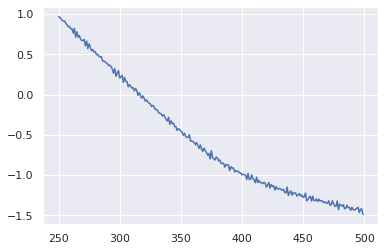

In [92]:
start_idx=250
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

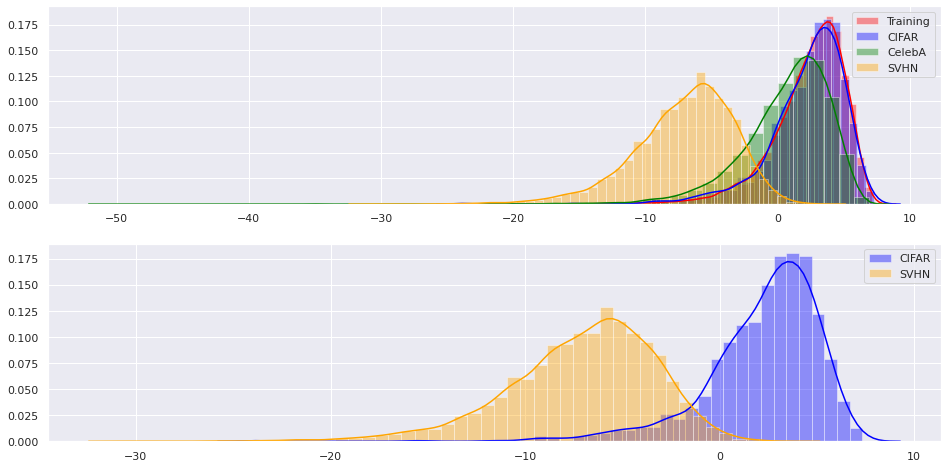

CPU times: user 1.31 s, sys: 20.1 ms, total: 1.33 s
Wall time: 1.32 s


In [87]:
%%time
train_score = distribution.log_prob(scaler.transform(X_train), dtype=np.float32).numpy()
test_score = distribution.log_prob(scaler.transform(X_test), dtype=np.float32).numpy()
outlier_score = distribution.log_prob(scaler.transform(outlier_data_1), dtype=np.float32).numpy()
outlier_score_2 = distribution.log_prob(scaler.transform(outlier_data_2), dtype=np.float32).numpy()

fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

In [79]:
outlier_score_2[0:-1:10].shape

(1000,)

In [89]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
metrics(outlier_score_2[0:-1:10], test_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9736
PR-AUC: 0.9957
Avg Prec: 0.9957
Inlier vs Outlier
----------------
ROC-AUC: 0.9731
PR-AUC: 0.9799
Avg Prec: 0.9799


(0.9730880000000001, 0.9798725853760307, 0.9798645706499773)

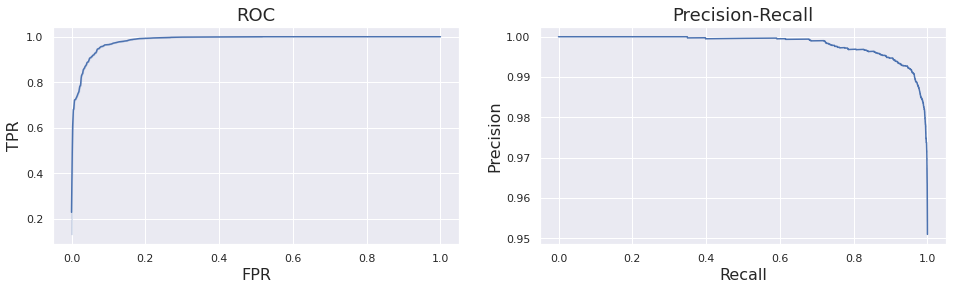

Inlier vs Outlier
----------------
ROC-AUC: 0.9840
PR-AUC: 0.9982
Avg Prec: 0.9982


In [76]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()

## GMM on Embeddings

In [106]:
%%time
X_train_embedding = reducer.transform(X_train)
X_test_embedding = reducer.transform(X_test)
outlier_1_embedding = reducer.transform(outlier_data_1[9000:])
outlier_2_embedding = reducer.transform(outlier_data_2[9000:])

CPU times: user 9.6 s, sys: 340 ms, total: 9.94 s
Wall time: 9.82 s


In [155]:
outlier_train_embedding_1 = reducer.transform(outlier_data_1[:9000])
outlier_train_embedding_2 = reducer.transform(outlier_data_2[:9000])

In [107]:
X_train, X_test =  test_data[:9000], test_data[9000:]

In [131]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(20,101,10),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train_embedding)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   38.6s finished


CPU times: user 59.3 s, sys: 8.16 s, total: 1min 7s
Wall time: 43.4 s


Best: -2.327967 using {'GMM__covariance_type': 'full', 'GMM__n_components': 100}
---------------------------------------------------------------------------
-2.662801 (0.046925) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
-2.573499 (0.042412) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 30}
-2.506286 (0.047969) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 40}
-2.454949 (0.040034) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 50}
-2.428373 (0.039311) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 60}
-2.401051 (0.052309) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 70}
-2.368396 (0.039467) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 80}
-2.348367 (0.041998) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 90}
-2.327967 (0.038845) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 100}


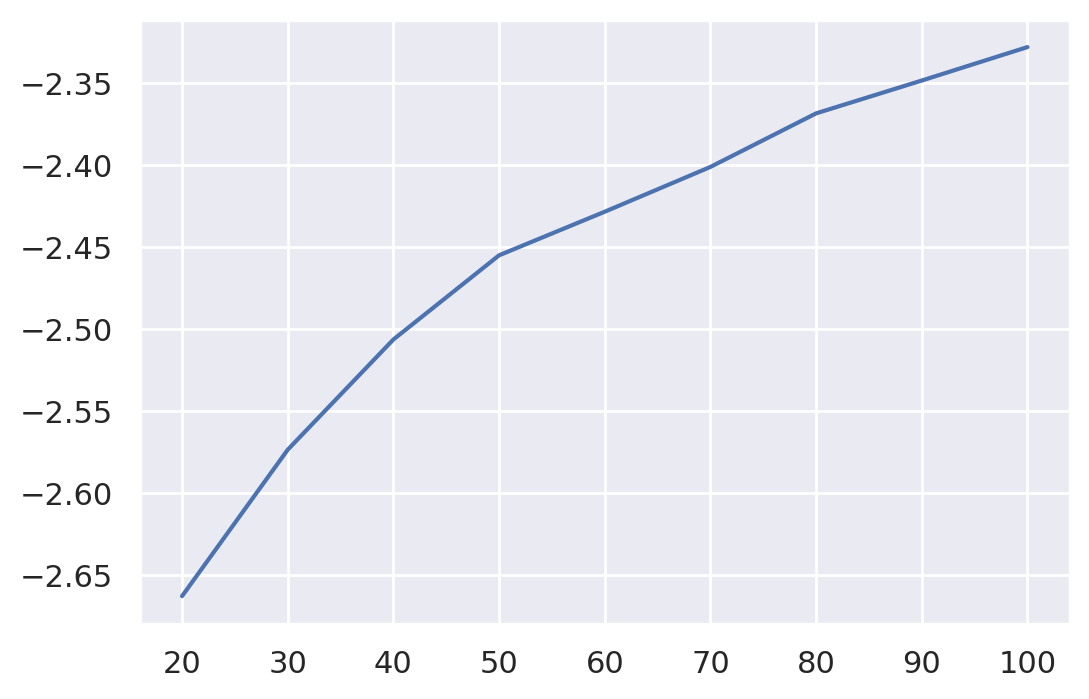

In [135]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [143]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': 20})

best_gmm_clf.fit(X_train_embedding)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_1_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_2_embedding)))

Training Likelihood: -2.651
CIFAR Likelihood: -2.703
CelebA Likelihood: -4.148
SVHN Likelihood: -21.181


In [ ]:
Training Likelihood: -2.535
CIFAR Likelihood: -2.615
CelebA Likelihood: -4.136
SVHN Likelihood: -21.257

In [144]:
train_score = best_gmm_clf.score_samples(X_train_embedding)
test_score = best_gmm_clf.score_samples(X_test_embedding)
outlier_score = best_gmm_clf.score_samples(outlier_1_embedding)
outlier_score_2 = best_gmm_clf.score_samples(outlier_2_embedding)

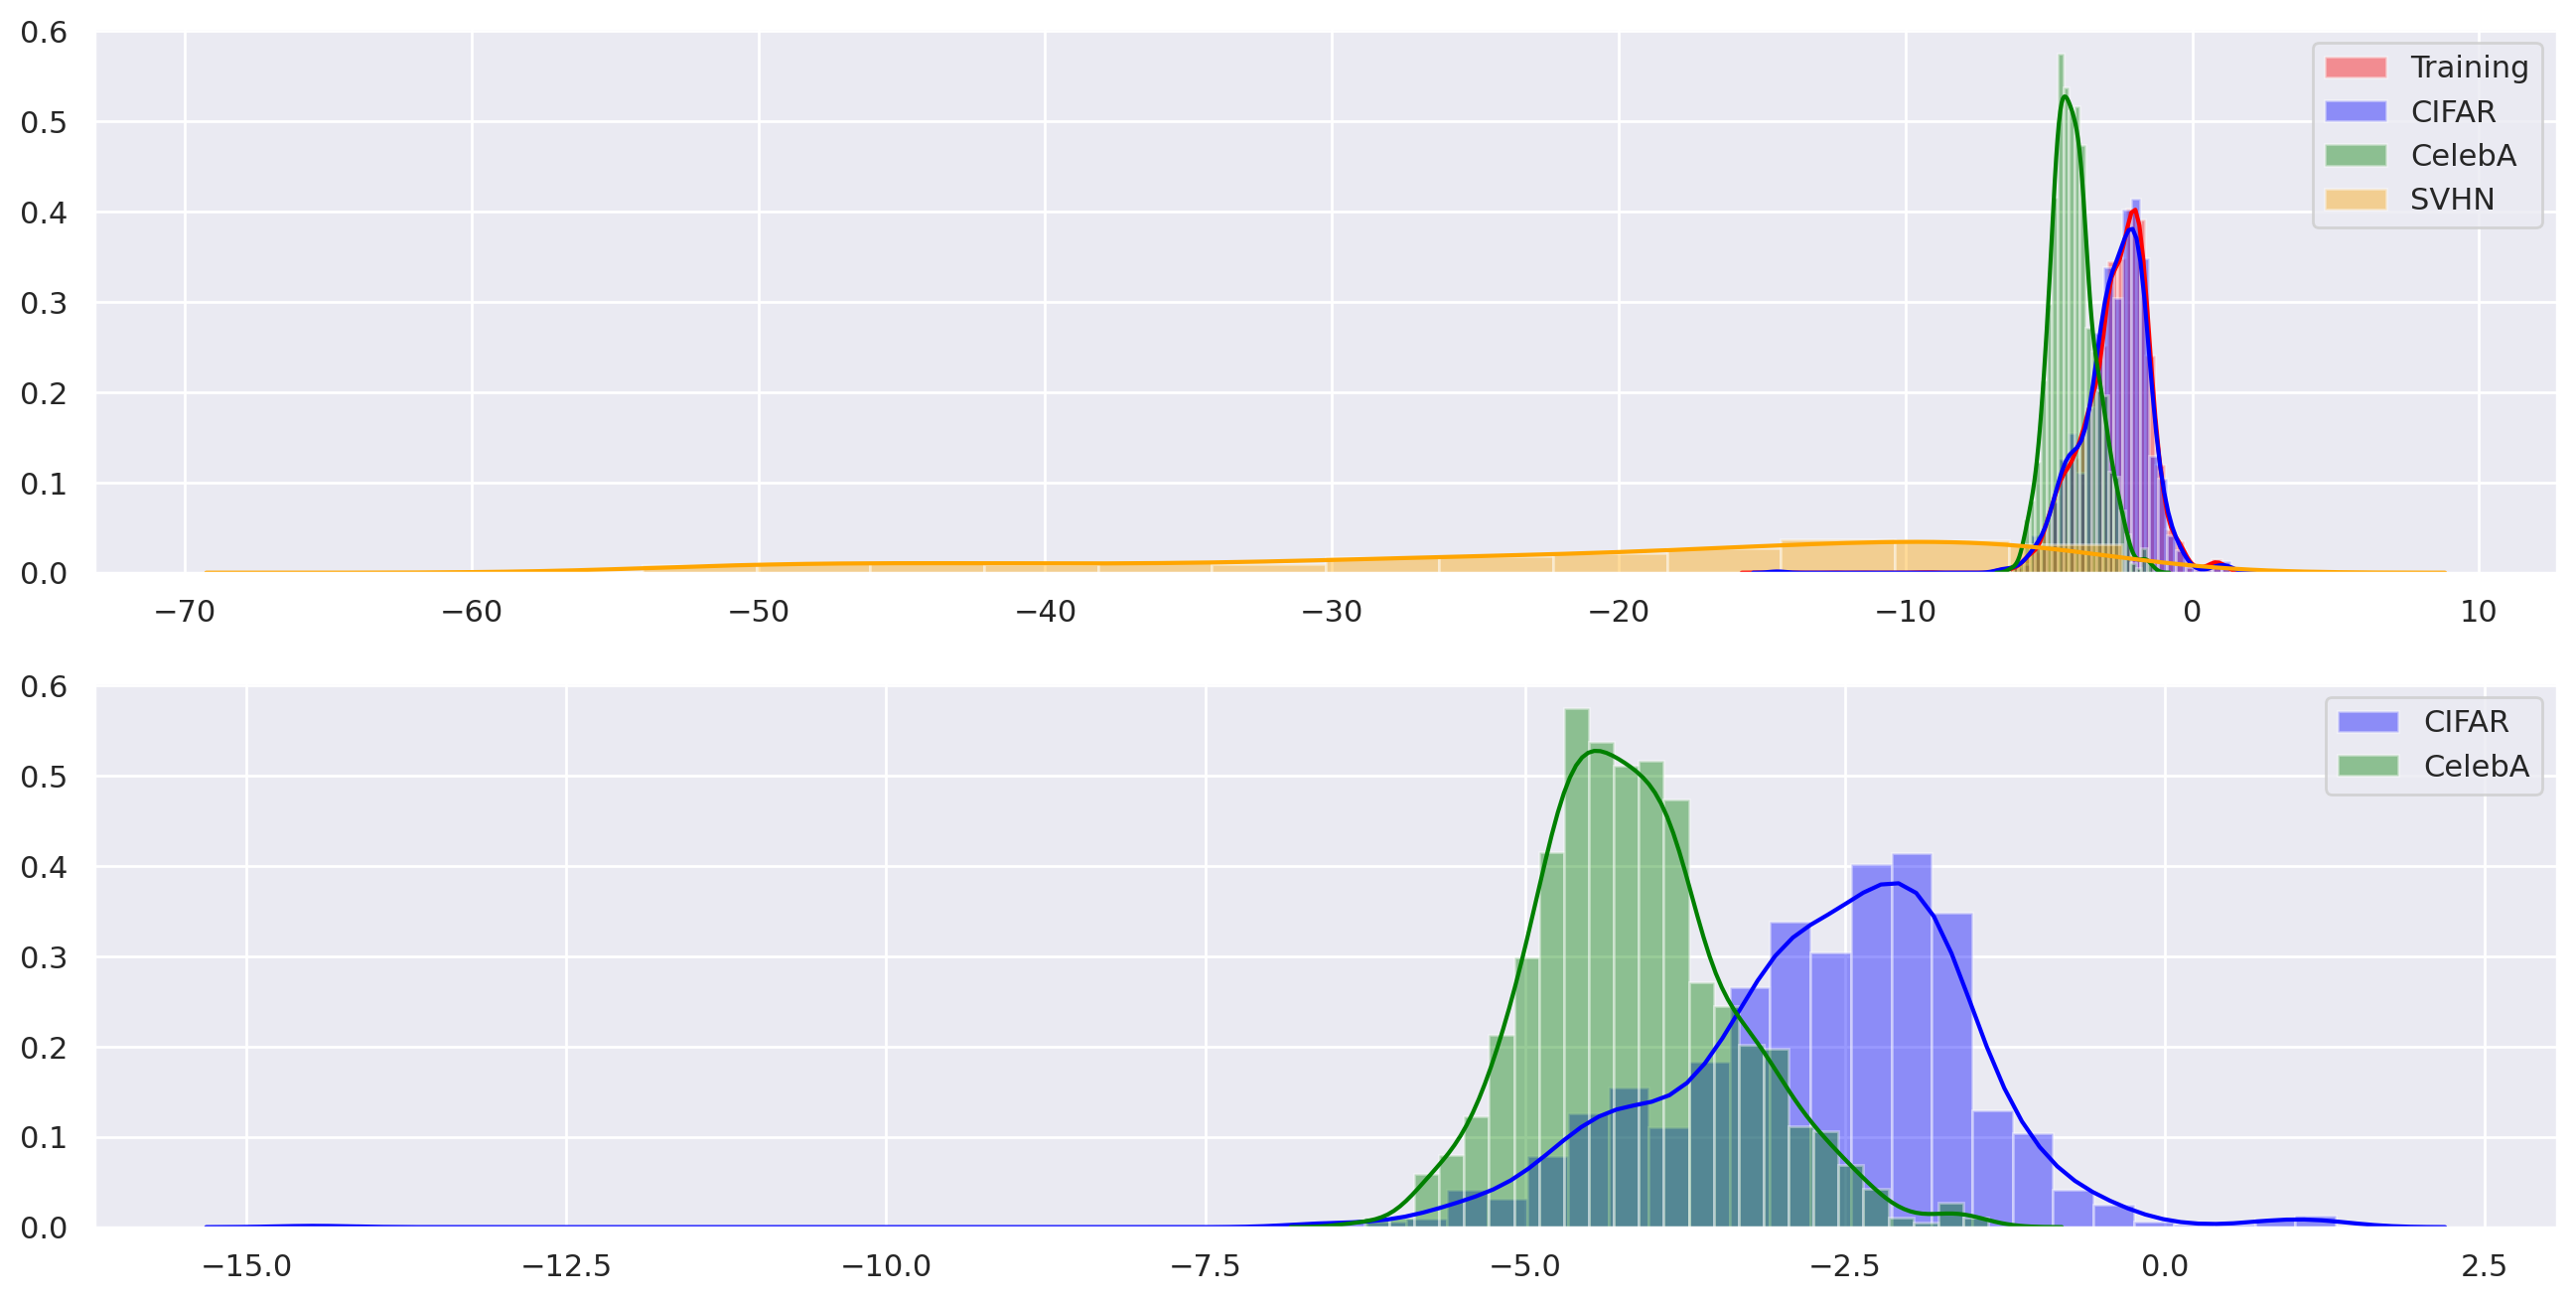

In [145]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def evaluate_GMM_emb(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train_embedding)
    
    test_score = gmm_clf.score_samples(X_test_embedding)
    outlier_score = gmm_clf.score_samples(outlier_train_embedding_1)
    outlier_score_2 = gmm_clf.score_samples(outlier_train_embedding_2)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [ ]:
%%time

max_n_component = 25
component_range = range(1, max_n_component+1, 1)

with ThreadPoolExecutor(max_workers = 4) as exc:
    result = list(exc.map(evaluate_GMM, component_range))
    
result = np.array(result)

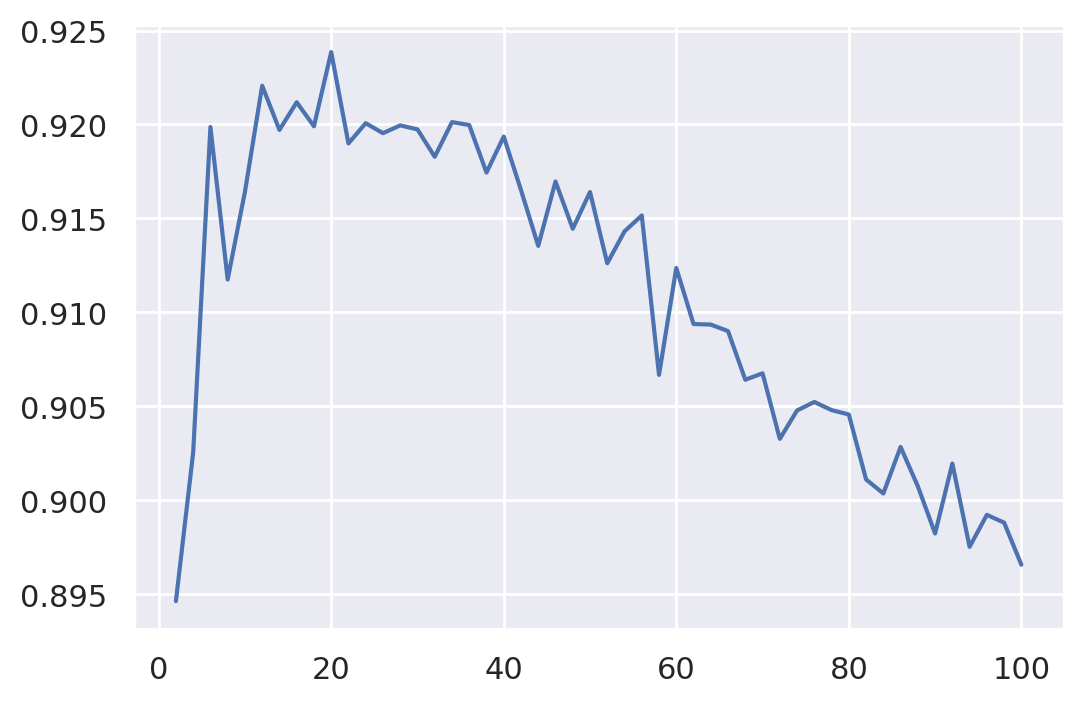

In [166]:
plt.plot(component_range, result)

print("Best -> {}:{:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [ ]:
y_true = np.concatenate((np.zeros(len(inlier_score)),
                         np.ones(len(outlier_score))))
y_scores = np.concatenate((inlier_score, outlier_score))


roc_auc = roc_auc_score(y_true,y_scores)

In [151]:
metrics(-test_score, -np.concatenate((outlier_score, outlier_score_2)), plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9197
PR-AUC: 0.9564
Avg Prec: 0.9564


**CIFAR vs CelebA**

In [146]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.8493
PR-AUC: 0.7716
Avg Prec: 0.7724


**CIFAR vs SVHN**

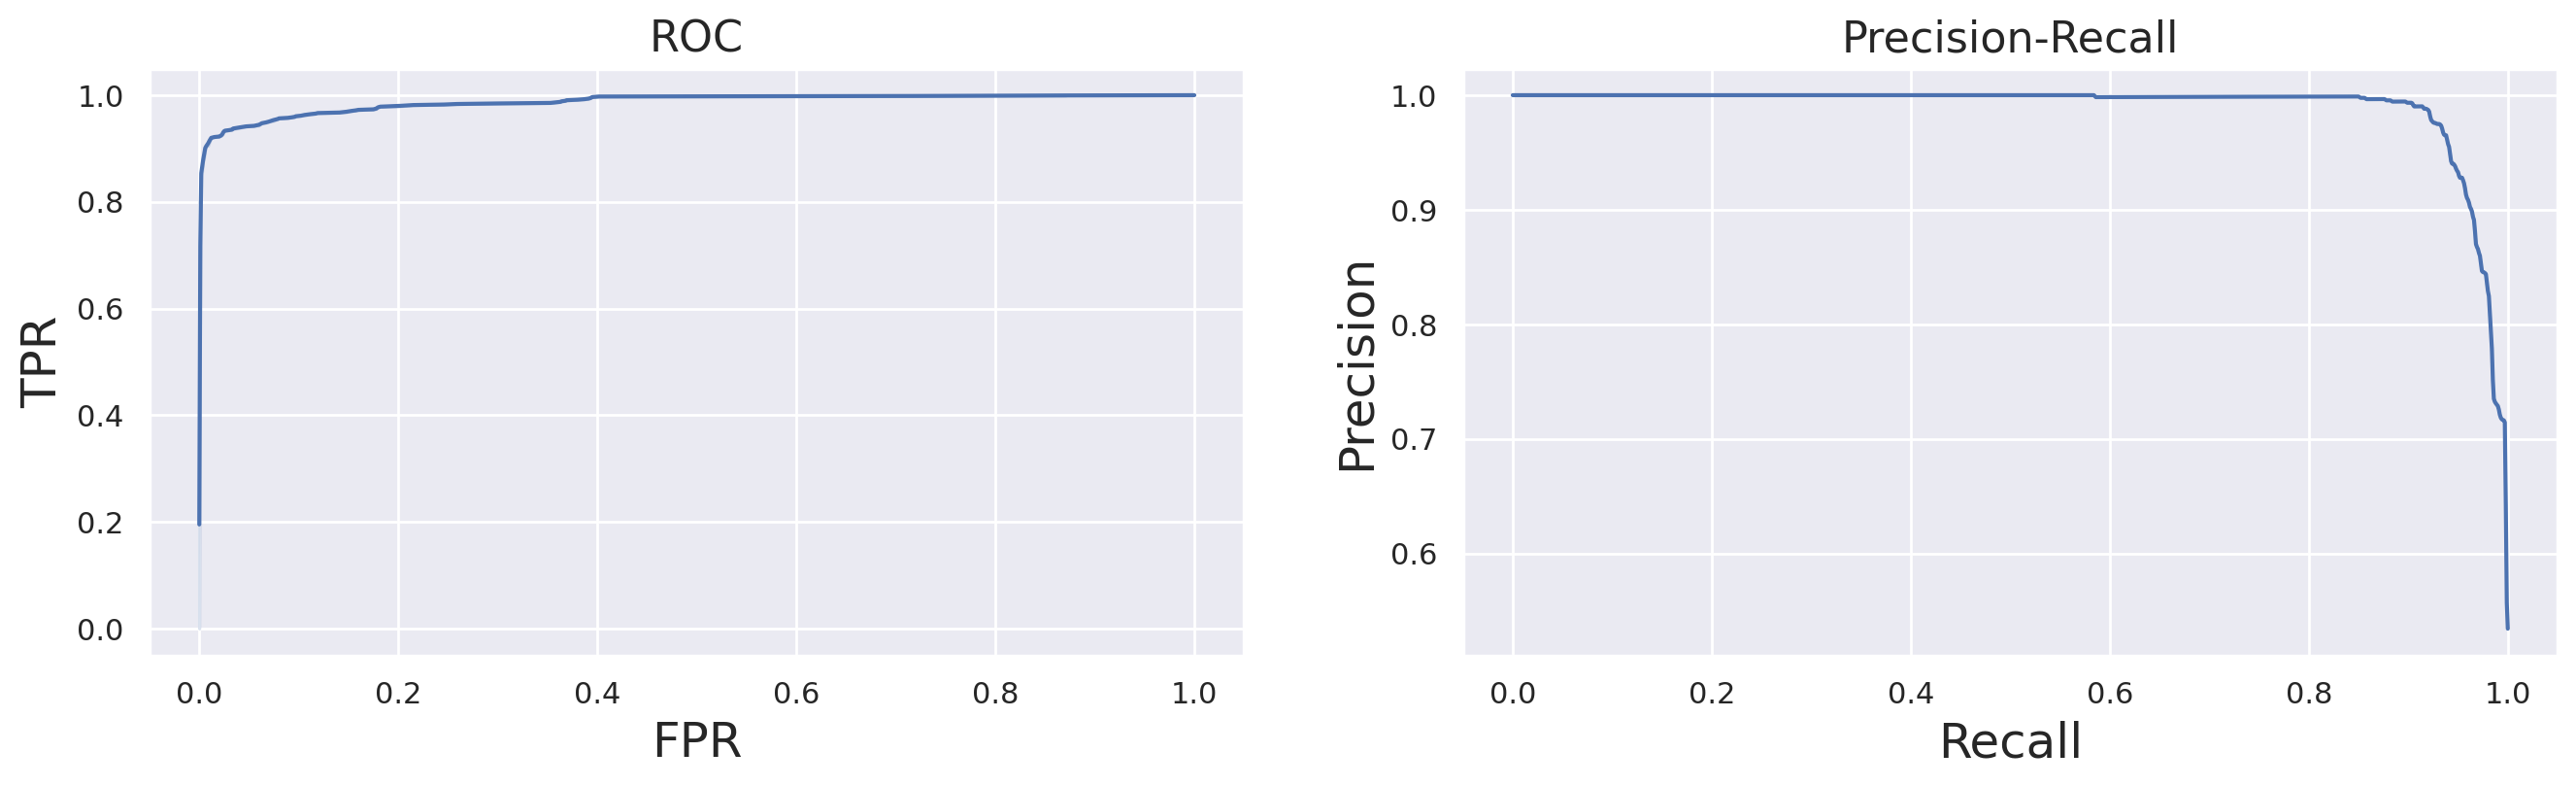

Inlier vs Outlier
----------------
ROC-AUC: 0.9868
PR-AUC: 0.9893
Avg Prec: 0.9893


In [119]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()